In [1]:
#classfier

In [36]:
from __future__ import print_function, division
import numpy as np
import os
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import keras as K
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold as KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RF
import xgboost as xgb
import pickle
from skimage.measure import label,regionprops

In [3]:
cd /home/chenxupeng/projects/pr

/home/chenxupeng/projects/pr


In [ ]:
#准备数据
images_train = {}
images_test={}
masks_train={}
masks_test_true ={}

for i in range(5):
    f =  h5py.File('/home/chenxupeng/projects/pr/preprocess/forunet/segment/cv_'+str(i)+'_224*224')
    images_train[i] = f['images_train_'+str(i)][:,:,:,:]  
    images_test[i] = f['images_test_'+str(i)][:,:,:,:]  
    masks_train[i] = f['masks_train_'+str(i)][:,:,:,:]  
    masks_test_true[i] =f['masks_test_'+str(i)][:,:,:,:]  

In [ ]:
#经过多轮训练，每张图上有多个区域，我们再用Unet对负样本进行训练，再训练一个classifier来判断哪层有nodule
#X： 特征
#y： 有结节/不是结节
#classifier：  利用特征的机器学习模型

#提取结节特征，存到一行，与label对应


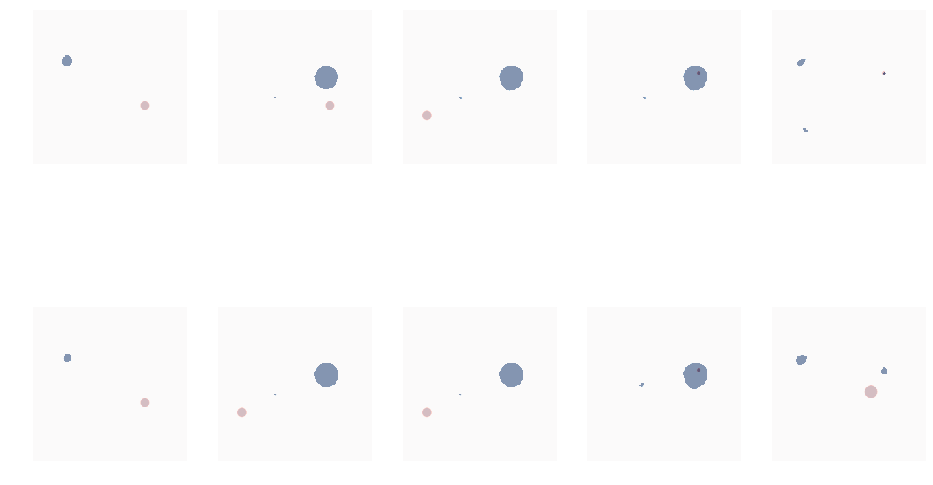

In [63]:
masks_test = np.load('/home/chenxupeng/projects/pr/output/masksTestPredicted_4_1.npy')
fig, ax = plt.subplots(2, 5, figsize=(16,10))
for i in range(5):
    for j in range(2):
        ax[j,i].imshow(masks_test_true[0][100+2*i+j][0],'Reds',alpha = 0.5)
        ax[j,i].imshow(masks_test[100+2*i+j][0],'Blues',alpha = 0.5)
        ax[j,i].set_axis_off()
plt.show()

In [6]:
np.sum(masks_train[0][0][0])

13954.0

In [5]:
#predicted mask 

In [24]:
predicted_mask = {}
for i in range(5):
    predicted_mask[i] = np.load('/home/chenxupeng/projects/pr/output/masksTestPredicted_'+str(i)+'.npy')

In [10]:
predicted_mask[0].shape

(200, 1, 224, 224)

In [32]:
#找到每个连通区域 以及获得面积
def getRegionFromMap(slice_npy):
    thr = np.where(slice_npy > np.mean(slice_npy),0.,1.0)
    label_image = label(thr)
    labels = label_image.astype(int)
    regions = regionprops(labels)
    return regions

In [50]:
slice_npy = predicted_mask[0][0][0]
thr = np.where(slice_npy > np.mean(slice_npy),0.,1.0)
label_image = label(thr)
labels = label_image.astype(int)
regions = regionprops(labels)

In [54]:
regions

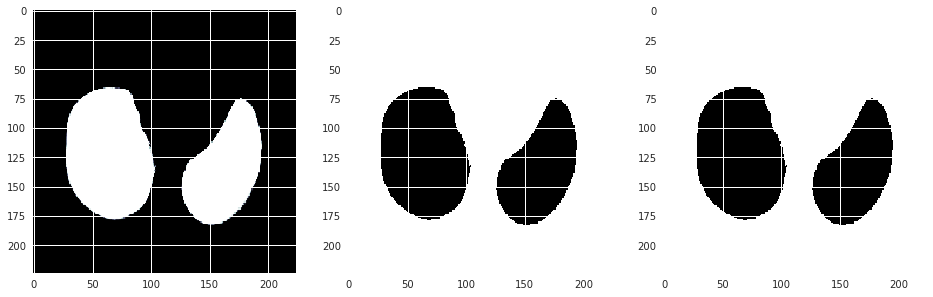

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(16,10))
ax[0].imshow(predicted_mask[0][0][0],'bone')
ax[1].imshow(thr,'bone')
ax[2].imshow(labels,'bone')
plt.show()

In [64]:
def getRegionMetricRow(array):
    seg = array
    nslices = seg.shape[0]

    #metrics
    totalArea = 0.0000000001
    avgArea = 0.
    maxArea = 0.
    avgEcc = 0.
    avgEquivlentDiameter = 0.
    stdEquivlentDiameter = 0.
    weightedX = 0.
    weightedY = 0.
    numNodes = 0.
    numNodesperSlice = 0.

    #maxAllowedArea = 0.10 * 224 * 224

    areas = []
    eqDiameters = []
    for slicen in range(nslices):
        regions = getRegionFromMap(seg[slicen,0,:,:])
        for region in regions:
            totalArea += region.area
            areas.append(region.area)
            avgEcc += region.eccentricity
            avgEquivlentDiameter += region.equivalent_diameter
            eqDiameters.append(region.equivalent_diameter)
            weightedX += region.centroid[0]*region.area
            weightedY += region.centroid[1]*region.area
            numNodes += 1

    weightedX = weightedX / totalArea 
    weightedY = weightedY / totalArea
    avgArea = totalArea / numNodes
    avgEcc = avgEcc / numNodes
    avgEquivlentDiameter = avgEquivlentDiameter / numNodes
    stdEquivlentDiameter = np.std(eqDiameters)
    maxArea = max(areas)
    numNodesperSlice = numNodes*1. / nslices
    return np.array([avgArea,maxArea,avgEcc,avgEquivlentDiameter,\
                     stdEquivlentDiameter, weightedX, weightedY, numNodes, numNodesperSlice])

In [59]:
predicted_mask[0][:1].shape

(1, 1, 224, 224)

In [65]:
getRegionMetricRow(predicted_mask[0][:1])

array([  3.88310000e+04,   3.88310000e+04,   3.08949407e-01,
         2.22353693e+02,   0.00000000e+00,   1.06924519e+02,
         1.13518941e+02,   1.00000000e+00,   1.00000000e+00])

In [ ]:
def createFeatureDataset(nodfile):
    # dict with mapping between truth and 
    truthdata = pickle.load(open("/home/sander/truthdict.pkl",'r'))
    numfeatures = 9
    feature_array = np.zeros((len(nodfiles),numfeatures))
    truth_metric = np.zeros((len(nodfiles)))

    for i,nodfile in enumerate(nodfiles):
        patID = nodfile.split("_")[2]
        truth_metric[i] = truthdata[int(patID)]
        feature_array[i] = getRegionMetricRow(nodfile)

    np.save("dataY.npy", truth_metric)
    np.save("dataX.npy", feature_array)

In [ ]:
X = np.load("dataX.npy")
Y = np.load("dataY.npy")

kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = RF(n_estimators=100, n_jobs=3)
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print("Random Forest")
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# try XGBoost
print ("XGBoost")
kf = KFold(Y, n_folds=3)
y_pred = Y * 0
for train, test in kf:
    X_train, X_test, y_train, y_test = X[train,:], X[test,:], Y[train], Y[test]
    clf = xgb.XGBClassifier(objective="binary:logistic")
    clf.fit(X_train, y_train)
    y_pred[test] = clf.predict(X_test)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# All Cancer
print "Predicting all positive"
y_pred = np.ones(Y.shape)
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

# No Cancer
print "Predicting all negative"
y_pred = Y*0
print classification_report(Y, y_pred, target_names=["No Cancer", "Cancer"])
print("logloss",logloss(Y, y_pred))

In [ ]:
#针对训练的结果，其实我们的U-net给出了多个区域，在2D 上，如何判断究竟哪个是真正的结节？
#找连通区域，判断连通区域有没有包括结节坐标，给结节一个label   
# CNN model如resnet  VGG等
#RCNN？ 确定每个结节的区域  